In [1]:
import numpy as np

import dreamcoder as dc
from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *

import time
from tqdm import trange
import random

%autoreload 2
%load_ext line_profiler

### Testing some circuits

In [2]:

n_qubit = 2
full_circuit = [n_qubit,
           [["cnot", 0, 1],
           ["swap", 0, 1],
           ["hadamard", 1]]
]

In [3]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [4]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [5]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [6]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [7]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
code.infer()
code.evaluate([])(no_op(n_qubit))

[[1, -1, 3], [['cnot', 1, 0]]]

In [8]:
code.infer()

tcircuit -> tcircuit

In [9]:
state_circuit_to_mat(code.evaluate([])(no_op(n_qubit)))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

### Testing some Tasks

In [10]:
tasks = makeTasks()

In [11]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h $0))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -3.8918202981106265)

In [16]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot $0))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -3.8918202981106265)

In [17]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -7.783640596221253)

In [18]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.567281192442506)

In [19]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv $0)))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(no_op(2))),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [16]:
with QiskitTester(code.evaluate([])(no_op(3))) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [17]:
with QiskitTester(code.evaluate([])(no_op(2))) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [15]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size $0))) (lambda (mv $0))) $0)))")
code.evaluate([])(no_op(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.83434397769155)

In [22]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) $0 )))))")
print_circuit(code.evaluate([])(no_op(3)))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -55.01960974404685)

In [23]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) ) $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [24]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) )  $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

### Profile bottom-up enumeration

In [13]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=6,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="bottom", 
    useRecognitionModel=False,
    enumerationTimeout=6,#-g
    compressor="pypy")   #ocaml, python, pypy  


CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK]
                             [-p PSEUDOCOUNTS] [-b AIC] [-l STRUCTUREPENALTY]
                             [-a ARITY] [-c CPUS] [--no-cuda]
                             [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE]
                             [-g] [-d] [--no-consolidation]
                             [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,bottom,python}]
                             [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                             [--matrixRank MATRIXRANK] 

In [14]:
# %lprun -f dc.domains.quantum_algorithms.primitives.tensor_contraction -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood -f dc.domains.quantum_algorithms.primitives.execute_quantum_algorithm -f full_circuit_to_mat -f dc.enumeration.multicoreEnumeration main(arguments)
main(arguments)

Running EC on 01-mar-grp-0020 @ 2022-04-03 20:06:17.653038 with 8 CPUs and parameters:
	 noConsolidation  =  False
	 iterations  =  6
	 enumerationTimeout  =  6
	 useRecognitionModel  =  False
	 topk_use_only_likelihood  =  False
	 pseudoCounts  =  10
	 aic  =  1.0
	 structurePenalty  =  1
	 arity  =  3
	 taskReranker  =  default
	 storeTaskMetrics  =  True
	 rewriteTaskMetrics  =  False
	 maximumFrontier  =  5
	 solver  =  bottom
	 topK  =  2
	 evaluationTimeout  =  0.01
	 cuda  =  False

Currently using this much memory: 208424960
Currently using this much memory: 208429056
Using a waking task batch of size: 19
Disabling parallelism on the Python side because we only have one job.
If you are using ocaml or bottom, there could still be parallelism.
(frontend) Launching int -> tcircuit (19 tasks) w/ 8 CPUs. 0.000000 <= MDL < 6.000000. Timeout 6.000000.
PANIC! Exception in child worker: [Errno 2] No such file or directory: 'pypy3': 'pypy3'
Traceback (most recent call last):
  File "/Use

AssertionError: 

In [14]:
code = dc.program.Program.parse("(lambda ((rep (inc(inc(dec 0))) (lambda (mv $0))) $0))")
code.evaluate([])(no_op(5))
code.infer()
tasks[0].logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(-inf, -13.328818040700815)

## Recognition model

In [12]:
print(grammar)

continuation : tcircuit
0.000000	t0	$_
0.000000	tcircuit -> tcircuit	mv
0.000000	tcircuit -> tcircuit	mv_r
0.000000	tcircuit -> tcircuit	minv
0.000000	tcircuit -> tcircuit	h
0.000000	tcircuit -> tcircuit	cnot
0.000000	int -> (tcircuit -> tcircuit) -> tcircuit -> tcircuit	rep
0.000000	int	0
0.000000	int -> int	inc
0.000000	int -> int	dec
0.000000	tcircuit -> int	size


In [13]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))

In [9]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=False)

In [10]:
for i in range(200):
    print(next(iterator))

[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4


(lambda $0)


 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8


(lambda (mv $0))
(lambda (mv_r $0))
(lambda (minv $0))
(lambda (h $0))
(lambda (cnot $0))


 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12


(lambda (mv (mv $0)))
(lambda (mv (mv_r $0)))
(lambda (mv (minv $0)))
(lambda (mv (h $0)))
(lambda (mv (cnot $0)))
(lambda (mv_r (mv $0)))
(lambda (mv_r (mv_r $0)))
(lambda (mv_r (minv $0)))
(lambda (mv_r (h $0)))
(lambda (mv_r (cnot $0)))
(lambda (minv (mv $0)))
(lambda (minv (mv_r $0)))
(lambda (minv (minv $0)))
(lambda (minv (h $0)))
(lambda (minv (cnot $0)))
(lambda (h (mv $0)))
(lambda (h (mv_r $0)))
(lambda (h (minv $0)))
(lambda (h (h $0)))
(lambda (h (cnot $0)))
(lambda (cnot (mv $0)))
(lambda (cnot (mv_r $0)))
(lambda (cnot (minv $0)))
(lambda (cnot (h $0)))
(lambda (cnot (cnot $0)))


 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15


(lambda (rep 0 (lambda $0) $0))


 -- Bottom up enumeration, cost 16


(lambda (mv (mv (mv $0))))
(lambda (mv (mv (mv_r $0))))
(lambda (mv (mv (minv $0))))
(lambda (mv (mv (h $0))))
(lambda (mv (mv (cnot $0))))
(lambda (mv (mv_r (mv $0))))
(lambda (mv (mv_r (mv_r $0))))
(lambda (mv (mv_r (minv $0))))
(lambda (mv (mv_r (h $0))))
(lambda (mv (mv_r (cnot $0))))
(lambda (mv (minv (mv $0))))
(lambda (mv (minv (mv_r $0))))
(lambda (mv (minv (minv $0))))
(lambda (mv (minv (h $0))))
(lambda (mv (minv (cnot $0))))
(lambda (mv (h (mv $0))))
(lambda (mv (h (mv_r $0))))
(lambda (mv (h (minv $0))))
(lambda (mv (h (h $0))))
(lambda (mv (h (cnot $0))))
(lambda (mv (cnot (mv $0))))
(lambda (mv (cnot (mv_r $0))))
(lambda (mv (cnot (minv $0))))
(lambda (mv (cnot (h $0))))
(lambda (mv (cnot (cnot $0))))
(lambda (mv_r (mv (mv $0))))
(lambda (mv_r (mv (mv_r $0))))
(lambda (mv_r (mv (minv $0))))
(lambda (mv_r (mv (h $0))))
(lambda (mv_r (mv (cnot $0))))
(lambda (mv_r (mv_r (mv $0))))
(lambda (mv_r (mv_r (mv_r $0))))
(lambda (mv_r (mv_r (minv $0))))
(lambda (mv_r (mv_r (h $0)))

 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18


(lambda (rep (inc 0) (lambda $0) $0))
(lambda (rep (dec 0) (lambda $0) $0))


 -- Bottom up enumeration, cost 19


(lambda (mv (rep 0 (lambda $0) $0)))
(lambda (mv_r (rep 0 (lambda $0) $0)))
(lambda (minv (rep 0 (lambda $0) $0)))
(lambda (h (rep 0 (lambda $0) $0)))
(lambda (cnot (rep 0 (lambda $0) $0)))
(lambda (rep 0 (lambda $0) (mv $0)))
(lambda (rep 0 (lambda $0) (mv_r $0)))
(lambda (rep 0 (lambda $0) (minv $0)))
(lambda (rep 0 (lambda $0) (h $0)))
(lambda (rep 0 (lambda $0) (cnot $0)))
(lambda (rep 0 (lambda (mv $0)) $0))
(lambda (rep 0 (lambda (mv_r $0)) $0))
(lambda (rep 0 (lambda (minv $0)) $0))
(lambda (rep 0 (lambda (h $0)) $0))
(lambda (rep 0 (lambda (cnot $0)) $0))
(lambda (rep (size $0) (lambda $0) $0))


 -- Bottom up enumeration, cost 20


(lambda (mv (mv (mv (mv $0)))))
(lambda (mv (mv (mv (mv_r $0)))))
(lambda (mv (mv (mv (minv $0)))))
(lambda (mv (mv (mv (h $0)))))
(lambda (mv (mv (mv (cnot $0)))))
(lambda (mv (mv (mv_r (mv $0)))))
(lambda (mv (mv (mv_r (mv_r $0)))))
(lambda (mv (mv (mv_r (minv $0)))))
(lambda (mv (mv (mv_r (h $0)))))
(lambda (mv (mv (mv_r (cnot $0)))))
(lambda (mv (mv (minv (mv $0)))))
(lambda (mv (mv (minv (mv_r $0)))))
(lambda (mv (mv (minv (minv $0)))))
(lambda (mv (mv (minv (h $0)))))
(lambda (mv (mv (minv (cnot $0)))))
(lambda (mv (mv (h (mv $0)))))
(lambda (mv (mv (h (mv_r $0)))))
(lambda (mv (mv (h (minv $0)))))
(lambda (mv (mv (h (h $0)))))
(lambda (mv (mv (h (cnot $0)))))
(lambda (mv (mv (cnot (mv $0)))))
(lambda (mv (mv (cnot (mv_r $0)))))
(lambda (mv (mv (cnot (minv $0)))))
(lambda (mv (mv (cnot (h $0)))))
(lambda (mv (mv (cnot (cnot $0)))))


In [8]:
dc.program.Program.parse("(lambda (mv (h (h  $0))))").evaluate([])(no_op(3))

[[1, 1, 3], [['hadamard', 0], ['hadamard', 0]]]

In [11]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=True)

In [12]:
for i in range(200): # there are no reps anymore!
    print(next(iterator))

[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4


TypeError: 'NoneType' object is not subscriptable

In [13]:
print(restricted_pcfg)

start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= $0			-1.9459101490553132

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size	0x(tcircuit, (tcircuit,))		-1.3862943611198906


In [14]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=6, 
                                                      circuit_execution_function=state_circuit_to_mat,no_op=no_op,
                                                      observational_equivalence=True,)

[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4
 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8
 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12
 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15
 -- Bottom up enumeration, cost 16
 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18
 -- Bottom up enumeration, cost 19
 -- Bottom up enumeration, cost 20
 -- Bottom up enumeration, cost 21
 -- Bottom up enumeration, cost 22
 -- Bottom up enumeration, cost 23
 -- Bottom up enumeration, cost 24
 -- Bottom up enumeration, cost 25
 -- Bottom up enumeration, cost 26
 -- Bottom up enumeration, cost 27
 -- Bottom up enu

In [16]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,timeout=6, 
                                                circuit_execution_function=full_circuit_to_mat, no_op=f_no_op)

[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4
 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8
 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12
 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15
 -- Bottom up enumeration, cost 16
 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18
 -- Bottom up enumeration, cost 19
 -- Bottom up enumeration, cost 20
 -- Bottom up enumeration, cost 21
 -- Bottom up enumeration, cost 22
 -- Bottom up enumeration, cost 23
 -- Bottom up enumeration, cost 24
 -- Bottom up enumeration, cost 25
 -- Bottom up enumeration, cost 26
 -- Bottom up enumeration, cost 27
 -- Bottom up enu

In [ ]:
# Augment the program set by merging two random programs

In [24]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys(): # same output on tested
        full_task = full_dictionary[unitary]["task"]
        restricted_task = restricted_dictionary[unitary]["task"]
        matched_programs.append([full_task, 
                                    restricted_task, 
                                    max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 1466 programs


In [23]:
matched_programs

[['(lambda $0)', '(lambda $0)', 0.00563502311706543],
 ['(lambda (fh $0 0))', '(lambda (h $0))', 0.009095191955566406],
 ['(lambda (fh $0 (inc 0)))', '(lambda (h (mv $0)))', 0.014990806579589844],
 ['(lambda (fh $0 (inc (inc 0))))',
  '(lambda (rep (inc 0) (lambda (mv_r (h $0))) (mv (mv $0))))',
  0.6374366283416748],
 ['(lambda (fh $0 (dec (fsize $0))))',
  '(lambda (rep (dec (size $0)) (lambda (mv_r (h $0))) (h (rep (dec (size $0)) (lambda (h (mv $0))) $0))))',
  256.3268585205078],
 ['(lambda (fcnot $0 0 (inc 0)))', '(lambda (cnot $0))', 0.015032052993774414],
 ['(lambda (fcnot $0 (inc 0) 0))',
  '(lambda (rep (inc 0) (lambda (rep (size $0) (lambda (minv $0)) (mv_r (cnot (mv $0))))) (minv $0)))',
  56.5738410949707],
 ['(lambda (fswap $0 0 (inc 0)))',
  '(lambda (cnot (rep (inc 0) (lambda (minv (mv_r (cnot (mv $0))))) (minv (cnot $0)))))',
  12.399802446365356],
 ['(lambda (fh (fh $0 0) (inc 0)))',
  '(lambda (h (minv (mv_r (h (mv $0))))))',
  0.11289095878601074],
 ['(lambda (fcnot

In [ ]:
#weird problem with rep - meaningless programs

In [20]:
print_circuit(dc.program.Program.parse(matched_programs[10][0]).evaluate([])(f_no_op(3)))
print_circuit(dc.program.Program.parse(matched_programs[10][1]).evaluate([])(no_op(3)))

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
q_2: ──────────
               
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
q_2: ──────────
               


In [21]:
sorted(list(restricted_dictionary.values()),key=lambda d: d["time"])

[{'task': '(lambda $0)',
  'circuits': [[[0, 1, 3], []], [[0, 1, 4], []], [[0, 1, 5], []]],
  'time': 0.008686065673828125},
 {'task': '(lambda (h $0))',
  'circuits': [[[0, 1, 3], [['hadamard', 0]]],
   [[0, 1, 4], [['hadamard', 0]]],
   [[0, 1, 5], [['hadamard', 0]]]],
  'time': 0.015732288360595703},
 {'task': '(lambda (cnot $0))',
  'circuits': [[[0, 1, 3], [['cnot', 0, 1]]],
   [[0, 1, 4], [['cnot', 0, 1]]],
   [[0, 1, 5], [['cnot', 0, 1]]]],
  'time': 0.016884326934814453},
 {'task': '(lambda (h (mv $0)))',
  'circuits': [[[1, 1, 3], [['hadamard', 1]]],
   [[1, 1, 4], [['hadamard', 1]]],
   [[1, 1, 5], [['hadamard', 1]]]],
  'time': 0.027305126190185547},
 {'task': '(lambda (h (cnot $0)))',
  'circuits': [[[0, 1, 3], [['cnot', 0, 1], ['hadamard', 0]]],
   [[0, 1, 4], [['cnot', 0, 1], ['hadamard', 0]]],
   [[0, 1, 5], [['cnot', 0, 1], ['hadamard', 0]]]],
  'time': 0.028276920318603516},
 {'task': '(lambda (cnot (mv $0)))',
  'circuits': [[[1, 1, 3], [['cnot', 1, 2]]],
   [[1, 1, 4

Save and load programs

In [14]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","matched_programs")

In [19]:
with open(save_path,"wb") as f:
    pickle.dump(matched_programs, f)
    
with open(save_path+"_restricted","wb") as f:
    pickle.dump(restricted_dictionary, f)
    
with open(save_path+"_full","wb") as f:
    pickle.dump(full_dictionary, f)

In [15]:
with open(save_path,"rb") as f:
        matched_programs = pickle.load(f)
        
with open(save_path+"_restricted","rb") as f:
        restricted_dictionary = pickle.load(f)
        
with open(save_path+"_full","rb") as f:
        full_dictionary = pickle.load(f)
        
        
print(f"Opened file with {len(matched_programs)} matched programs")

Opened file with 1466 matched programs


In [16]:
len(full_dictionary)

988062

In [17]:
len(restricted_dictionary)

40556

### Feature extractor for the recognition network

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [26]:
feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)
lr=0.00001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [27]:
batch_size = 32
n_steps = 60000
for _ in trange(n_steps):
    programs_batch = random.sample(matched_programs, batch_size)
    tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
                   for i, program in enumerate(programs_batch)]
    embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
    simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
    contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)
    
    summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]
    
    # summaries = [grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

    optimizer.zero_grad()
    recognition_model.zero_grad()
    
    features = recognition_model._MLP(embedding)
    lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
    loss = -lls.mean() 
    
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())

 30%|██▉       | 17889/60000 [1:05:14<2:33:34,  4.57it/s] 


KeyboardInterrupt: 

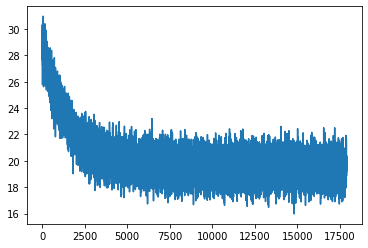

In [28]:
plt.figure()
plt.plot(losses)
plt.show()

In [38]:
i = 1000 # program we are testing
task = QuantumTask(i,lambda n_qubit, program=matched_programs[i]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
code =  dc.program.Program.parse(matched_programs[i][1])
embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)
grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)


(-30.015330809014166, tensor([-17.8723], grad_fn=<AddBackward0>))

In [37]:
print_circuit(dc.program.Program.parse(matched_programs[-100][1]).evaluate([])(no_op(4)))

          ┌───┐┌───┐┌───┐     ┌───┐     ┌───┐
q_0: ──■──┤ H ├┤ H ├┤ H ├──■──┤ H ├──■──┤ H ├
     ┌─┴─┐└───┘└───┘└───┘┌─┴─┐└───┘┌─┴─┐└───┘
q_1: ┤ X ├──■────────────┤ X ├─────┤ X ├─────
     └───┘┌─┴─┐          └───┘     └───┘     
q_2: ─────┤ X ├──────────────────────────────
          └───┘                              
q_3: ────────────────────────────────────────
                                             


In [32]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv( $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-7.783640596221253, tensor([-6.8125], grad_fn=<AddBackward0>))

In [33]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot  $0))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-15.567281192442506, tensor([-15.9545], grad_fn=<AddBackward0>))

In [34]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) )  $0 )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-53.633315382926966, tensor([-53.3285], grad_fn=<AddBackward0>))

In [35]:
task.logLikelihood(code)

0.0

In [ ]:
# check performance of BagOfWords
# improve recognition model -> GREAT
# use prefix matching for full tasks to train also on more complex tasks 
#   i.e. look for programs that solve the circuit up to a certain gate_i within a given timeout
# CHANGE WAY IN WHICH OBSERVATIONAL EQUIVALENCE IS CHECKED SO THAT 'REP' OPERATIONS ARE ALLOWED AGAIN

#### Enumerating arithmetic

In [ ]:
counter = 0
for i in iterator:
    counter +=1
    if counter<100:
        print(i)
    else: break

[(lambda 0)]


(lambda $0)
(lambda (inc $0))
(lambda (dec $0))
(lambda (inc (inc $0)))
(lambda (dec (dec $0)))
(lambda (inc (inc (inc $0))))
(lambda (dec (dec (dec $0))))
(lambda (inc (inc (inc (inc $0)))))
(lambda (dec (dec (dec (dec $0)))))
(lambda (inc (inc (inc (inc (inc $0))))))
(lambda (dec (dec (dec (dec (dec $0))))))
(lambda (inc (inc (inc (inc (inc (inc $0)))))))
(lambda (dec (dec (dec (dec (dec (dec $0)))))))
(lambda (inc (inc (inc (inc (inc (inc (inc $0))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec $0))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec $0))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))))
(lambda (d

### Program matching

In [ ]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
# print(restricted_pcfg)
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=60, circuit_execution_function=state_circuit_to_mat,no_op=no_op)

[(lambda 0)]


exception (lambda (mv_r $0))
exception (lambda (mv (mv (mv $0))))
exception (lambda (cnot (mv (mv $0))))
exception (lambda (mv (mv (mv (minv $0)))))
exception (lambda (mv (mv (mv (h $0)))))
exception (lambda (mv (mv (mv (cnot $0)))))
exception (lambda (mv (mv (h (mv $0)))))
exception (lambda (mv (mv (cnot (mv $0)))))
exception (lambda (mv (h (mv (mv $0)))))
exception (lambda (mv (cnot (mv (mv $0)))))
exception (lambda (mv_r (cnot (mv (mv $0)))))
exception (lambda (minv (cnot (mv (mv $0)))))
exception (lambda (h (mv (mv (mv $0)))))
exception (lambda (h (cnot (mv (mv $0)))))
exception (lambda (cnot (mv (mv (h $0)))))
exception (lambda (cnot (mv (mv (cnot $0)))))
exception (lambda (cnot (mv (h (mv $0)))))
exception (lambda (cnot (mv (cnot (mv $0)))))
exception (lambda (cnot (h (mv (mv $0)))))
exception (lambda (mv (mv (mv (minv (h $0))))))
exception (lambda (mv (mv (mv (minv (cnot $0))))))
exception (lambda (mv (mv (mv (h (cnot $0))))))
exception (lambda (mv (mv (mv (cnot (h $0))))))
exce

Enumerated 6124 programs


In [ ]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,timeout=60, circuit_execution_function=full_circuit_to_mat, no_op=f_no_op)

[(lambda 0)]
Enumerated 4872 programs


In [21]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(f_no_op(4)))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(no_op(4)))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 79 programs


In [58]:
def add_vertex(type, vertices):
    idx = len(vertices) + 1
    vertices.add((idx, type))
    return idx

def get_initial_bindings(n_bindings, vertices):
    return {i:add_vertex("input", vertices) for i in range(n_bindings)}

def get_relations(changed_vertices):
    relations = []
    changed_vertices_array = np.array(changed_vertices)
    
    # among inputs
    for i in range(len(changed_vertices_array)):
        for j in range(i+1, len(changed_vertices_array)):
            relations.append((f"input_{i}{j}", changed_vertices_array[i][0], changed_vertices_array[j][0]) )
    
    # among outputs
    for i in range(len(changed_vertices_array)):
        for j in range(i+1, len(changed_vertices_array)):
            relations.append((f"output_{i}{j}", changed_vertices_array[i][1], changed_vertices_array[j][1] ))
    
    # input - output
    for i in range(len(changed_vertices_array)):
        for j in range(len(changed_vertices_array)):
            relations.append((f"io_{i}{j}", changed_vertices_array[i][0], changed_vertices_array[j][1]))
    
    return relations

def get_graph(circuit, bindings, vertices, edges):
    if len(circuit)>0:
        current_op = circuit[0]
        new_bindings = bindings.copy()
        changed_vertices = []
        for i in current_op[1:]:
            new_bindings[i] = add_vertex(f"{current_op[0]}{i}", vertices)
            changed_vertices.append([bindings[i], new_bindings[i]])
            
        relations = get_relations(changed_vertices)
        edges.update(relations)
        get_graph(circuit[1:], new_bindings, vertices, edges)
        

In [63]:
all_vertices = set()
all_edges = set()

In [64]:
for matched_program in matched_programs:
    n_qubits = 4

    n_bindings, circuit = dc.program.Program.parse(matched_program[0]).evaluate([])(f_no_op(n_qubits))
    vertices = set()
    edges = set()
    bindings = get_initial_bindings(n_qubits, vertices)
    get_graph(circuit, bindings, vertices, edges)
    
    all_vertices.update(vertices)
    all_edges.update(edges)

In [67]:
all_vertices

{(1, 'input'),
 (2, 'input'),
 (3, 'input'),
 (4, 'input'),
 (5, 'cnot0'),
 (5, 'cnot1'),
 (5, 'cnot2'),
 (5, 'hadamard0'),
 (5, 'hadamard1'),
 (5, 'hadamard2'),
 (6, 'cnot0'),
 (6, 'cnot1'),
 (6, 'cnot2'),
 (6, 'hadamard1'),
 (6, 'hadamard2'),
 (7, 'cnot0'),
 (7, 'cnot1'),
 (7, 'cnot2'),
 (7, 'hadamard0'),
 (7, 'hadamard1'),
 (7, 'hadamard2'),
 (8, 'cnot0'),
 (8, 'cnot1'),
 (8, 'cnot2'),
 (8, 'hadamard0'),
 (8, 'hadamard1'),
 (8, 'hadamard2'),
 (8, 'swap0'),
 (9, 'cnot0'),
 (9, 'cnot1'),
 (9, 'cnot2'),
 (9, 'hadamard0'),
 (9, 'hadamard1'),
 (9, 'swap0'),
 (9, 'swap1'),
 (10, 'cnot1'),
 (10, 'hadamard0'),
 (10, 'hadamard1'),
 (10, 'swap1')}

In [68]:
all_edges

{('input_01', 1, 2),
 ('input_01', 1, 5),
 ('input_01', 1, 6),
 ('input_01', 1, 7),
 ('input_01', 2, 1),
 ('input_01', 2, 3),
 ('input_01', 2, 5),
 ('input_01', 3, 2),
 ('input_01', 3, 5),
 ('input_01', 5, 1),
 ('input_01', 5, 2),
 ('input_01', 5, 3),
 ('input_01', 5, 7),
 ('input_01', 6, 3),
 ('input_01', 6, 5),
 ('input_01', 6, 7),
 ('input_01', 7, 1),
 ('input_01', 7, 5),
 ('input_01', 7, 6),
 ('input_01', 8, 6),
 ('input_01', 8, 7),
 ('io_00', 1, 5),
 ('io_00', 1, 6),
 ('io_00', 1, 7),
 ('io_00', 1, 8),
 ('io_00', 2, 5),
 ('io_00', 2, 6),
 ('io_00', 3, 5),
 ('io_00', 3, 6),
 ('io_00', 3, 7),
 ('io_00', 3, 8),
 ('io_00', 5, 6),
 ('io_00', 5, 7),
 ('io_00', 5, 8),
 ('io_00', 5, 9),
 ('io_00', 6, 7),
 ('io_00', 6, 8),
 ('io_00', 6, 9),
 ('io_00', 7, 8),
 ('io_00', 7, 9),
 ('io_00', 8, 9),
 ('io_00', 8, 10),
 ('io_00', 9, 10),
 ('io_01', 1, 6),
 ('io_01', 1, 7),
 ('io_01', 1, 8),
 ('io_01', 1, 9),
 ('io_01', 2, 6),
 ('io_01', 2, 7),
 ('io_01', 3, 6),
 ('io_01', 3, 7),
 ('io_01', 5, 7),

In [66]:
vertices

{(1, 'input'),
 (2, 'input'),
 (3, 'input'),
 (4, 'input'),
 (5, 'cnot1'),
 (6, 'cnot0'),
 (7, 'cnot0'),
 (8, 'cnot2'),
 (9, 'swap0'),
 (10, 'swap1')}

In [62]:
edges # edges embedding

{('input_01', 2, 1),
 ('input_01', 6, 3),
 ('input_01', 7, 5),
 ('io_00', 2, 5),
 ('io_00', 6, 7),
 ('io_00', 7, 9),
 ('io_01', 2, 6),
 ('io_01', 6, 8),
 ('io_01', 7, 10),
 ('io_10', 1, 5),
 ('io_10', 3, 7),
 ('io_10', 5, 9),
 ('io_11', 1, 6),
 ('io_11', 3, 8),
 ('io_11', 5, 10),
 ('output_01', 5, 6),
 ('output_01', 7, 8),
 ('output_01', 9, 10)}

In [45]:
circuit

[['cnot', 1, 0], ['cnot', 0, 2], ['swap', 0, 1]]

In [46]:
vertices #embedding

{(1, 'input'),
 (2, 'input'),
 (3, 'input'),
 (4, 'input'),
 (5, 'cnot1'),
 (6, 'cnot0'),
 (7, 'cnot0'),
 (8, 'cnot2'),
 (9, 'swap0'),
 (10, 'swap1')}

In [ ]:
# How to convert the set into a vector that one can feed into a neural network?
# Not sure about the meaning of the number ID_vertex: I can put first H(1) then H(2) or do the opposite,
# get different vertex id but same output circuit
# Embedding should take into account values for multiple n_qubits values

# Task augmentation by merging to matched tasks
# Quantized enumeration should also return the unitaries so that we avoid recalculating them
# Big difference in number of enumerated "restricted" tasks and "full" 

In [ ]:
full_grammar.productions

[(0.0, tcircuit_full -> int -> tcircuit_full, fh),
 (0.0, tcircuit_full -> int -> int -> tcircuit_full, fcnot),
 (0.0, tcircuit_full -> int -> int -> tcircuit_full, fswap),
 (0.0, int, 0),
 (0.0, int -> int, inc),
 (0.0, int -> int, dec),
 (0.0, tcircuit_full -> int, fsize)]

#### GREAT feature for recognition model

In [7]:
import dreamcoder.great

In [8]:
feature_extr = dc.great.Great(layers=4, d_model=128)

In [11]:
full_task

NameError: name 'full_task' is not defined

In [13]:
matched_programs

NameError: name 'matched_programs' is not defined

Task(name=cz_01, request=int -> tcircuit, examples=[]